In [11]:
import pandas as pd
import pycountry

# 1. Load the two pieces
music_df = pd.read_csv('country_music_scores.csv')
happiness_df = pd.read_csv('world_happiness_2024.csv', sep=None, engine='python')

# 2. Fix Country Names (US -> United States)
def get_name(code):
    try:
        return pycountry.countries.get(alpha_2=code).name
    except:
        return None

music_df['Country_Name'] = music_df['Country_Code'].apply(get_name)

# 3. Merge them
# Find the happiness country column automatically
happ_col = [c for c in happiness_df.columns if 'country' in c.lower()][0]

final_df = pd.merge(
    music_df, 
    happiness_df, 
    left_on='Country_Name', 
    right_on=happ_col,
    how='inner'
)

# 4. SAVE IT
final_df.to_csv('final_project_dataset.csv', index=False)

print("SUCCESS!")
print(f"Created 'final_project_dataset.csv' with {len(final_df)} rows.")

SUCCESS!
Created 'final_project_dataset.csv' with 95 rows.


Successfully loaded 95 countries from final_project_dataset.csv.
Using Happiness Column: 'Ladder score'


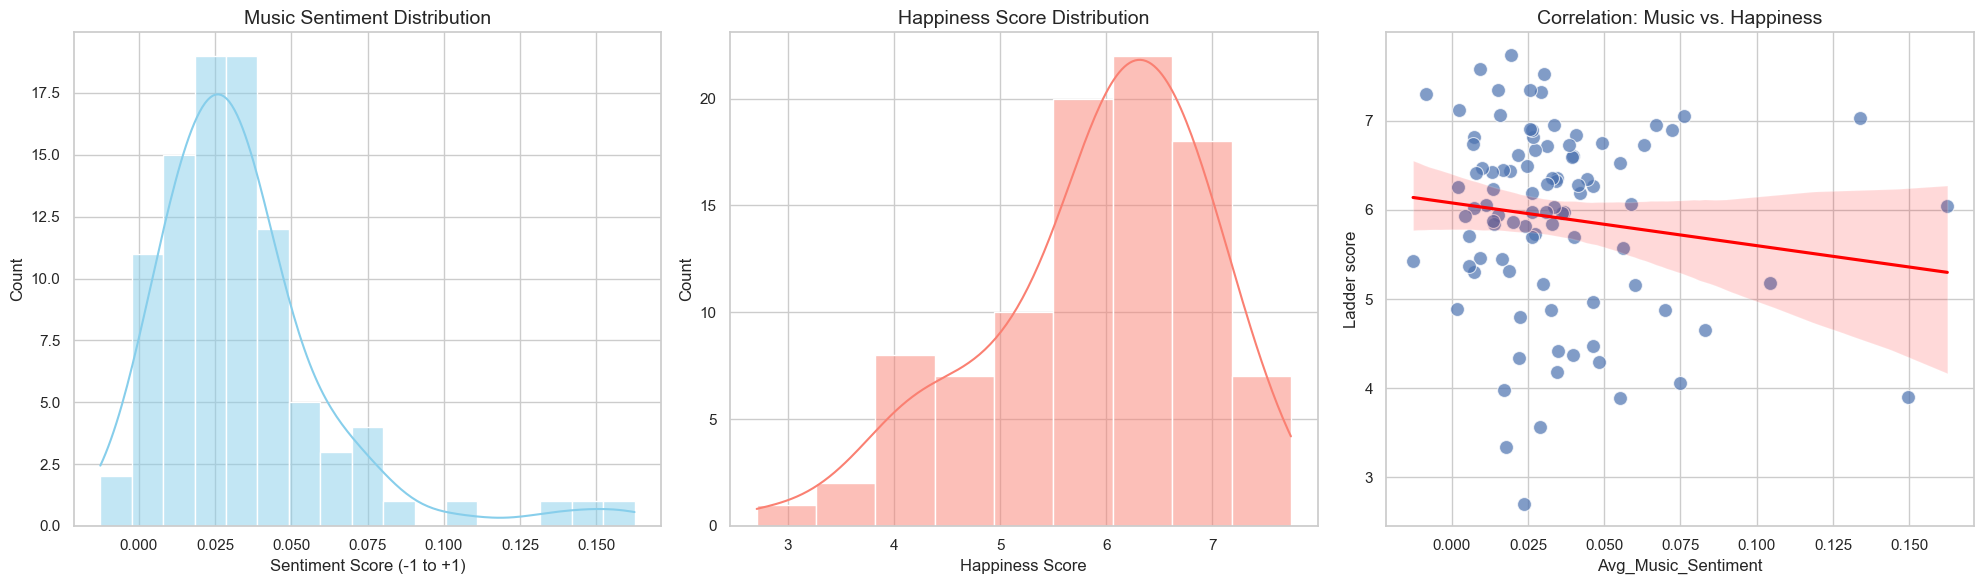

--- FINAL STATISTICAL FINDINGS ---
Correlation Coefficient: -0.1350
P-Value: 0.1920
CONCLUSION: No significant relationship found (Result might be random).


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

filename = 'final_project_dataset.csv'

try:
    final_df = pd.read_csv(filename)
    print(f"Successfully loaded {len(final_df)} countries from {filename}.")
    
    final_df['Avg_Music_Sentiment'] = pd.to_numeric(final_df['Avg_Music_Sentiment'], errors='coerce')
    
    # Identify the happiness column
    happiness_col = 'Ladder score' 
    if happiness_col not in final_df.columns:
        # Find the column if it has a slightly different name
        for col in final_df.columns:
            if 'ladder' in col.lower() or 'score' in col.lower():
                happiness_col = col
                break
    
    # Ensure happiness column is numeric
    if final_df[happiness_col].dtype == 'object':
         final_df[happiness_col] = final_df[happiness_col].str.replace(',', '.')
    final_df[happiness_col] = pd.to_numeric(final_df[happiness_col], errors='coerce')
    
    print(f"Using Happiness Column: '{happiness_col}'")

except FileNotFoundError:
    print(f"ERROR: Could not find '{filename}'. Make sure you saved it in the previous step!")

# --- VISUALIZATION (EDA) ---
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Chart 1: Music Sentiment Distribution
sns.histplot(final_df['Avg_Music_Sentiment'], kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Music Sentiment Distribution', fontsize=14)
axes[0].set_xlabel('Sentiment Score (-1 to +1)')

# Chart 2: Happiness Score Distribution
sns.histplot(final_df[happiness_col], kde=True, color='salmon', ax=axes[1])
axes[1].set_title('Happiness Score Distribution', fontsize=14)
axes[1].set_xlabel('Happiness Score')

# Chart 3: Scatter Plot (The Thesis Test)
sns.scatterplot(data=final_df, x='Avg_Music_Sentiment', y=happiness_col, s=100, alpha=0.7, ax=axes[2])
sns.regplot(data=final_df, x='Avg_Music_Sentiment', y=happiness_col, scatter=False, color='red', ax=axes[2])
axes[2].set_title('Correlation: Music vs. Happiness', fontsize=14)

plt.tight_layout()
plt.show()

# --- STATISTICS (Hypothesis Test) ---
correlation, p_value = stats.pearsonr(final_df['Avg_Music_Sentiment'], final_df[happiness_col])

print(f"--- FINAL STATISTICAL FINDINGS ---")
print(f"Correlation Coefficient: {correlation:.4f}")
print(f"P-Value: {p_value:.4f}")

if p_value < 0.05:
    print("CONCLUSION: Statistically Significant Relationship Found!")
else:
    print("CONCLUSION: No significant relationship found (Result might be random).")